In [28]:
import numpy as np
from dataclasses import dataclass, field
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import glob
import pandas as pd
import numpy as np
from ahrs.filters import madgwick
from ahrs.common.orientation import q2euler

from matplotlib.widgets import SpanSelector
from inspect import signature
from scipy import signal


In [29]:
# Constants
FS = 104                 # Sampling frequency [Hz]
DT = 1.0 / FS            # Sample period [s]
RAD_TO_DEG = 180.0 / np.pi
DEG_TO_RAD = np.pi / 180.0
DPS_IS_MILI = False

# Detection thresholds
ALTITUDE_THRESHOLD = 1.0  # degrees
AZIMUTH_THRESHOLD = 5.0   # degrees

# Csv path(s)
# csv_path = "raw_data/motion_data_eventful.csv"
csv_path = "test_01"

TAKE_OWN_TIMESTAMP = True

# Test names:
file_patterns = {
    "static_test": "*_static_*s.csv",
    "move_azimuth_test": "*_move_*az_*s.csv",
    "move_altitude_test": "*_move_*al_*s.csv",
    "vibration_test": "*_vibrations_*s.csv",
}

datasets = {}
    

In [30]:
def load_and_validate_imu_data(csv_path, expected_fs=104):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found: {csv_path}")

    df = pd.read_csv(csv_path)
    
    # Extract sensor data
    acc_data_mg = df[['accel_x_mg', 'accel_y_mg', 'accel_z_mg']].values
    gyro_data_raw = df[['gyro_x_dps', 'gyro_y_dps', 'gyro_z_dps']].values
    
    gyro_mean_magnitude = np.mean(np.sqrt(np.sum(gyro_data_raw**2, axis=1)))
    
    if gyro_mean_magnitude > 100:
        print("Detected: Gyroscope data is in millidegrees per second (mdps)")
        gyro_units = "mdps"
        gyro_data_dps = gyro_data_raw / 1000.0
        df['gyro_x_mdps'] = gyro_data_raw[:, 0]
        df['gyro_y_mdps'] = gyro_data_raw[:, 1] 
        df['gyro_z_mdps'] = gyro_data_raw[:, 2]
        df['gyro_x_dps'] = gyro_data_dps[:, 0]
        df['gyro_y_dps'] = gyro_data_dps[:, 1]
        df['gyro_z_dps'] = gyro_data_dps[:, 2]
    else:
        print("Detected: Gyroscope data is in degrees per second (dps)")
        gyro_units = "dps"
        gyro_data_dps = gyro_data_raw
        df['gyro_x_mdps'] = gyro_data_raw[:, 0] * 1000
        df['gyro_y_mdps'] = gyro_data_raw[:, 1] * 1000
        df['gyro_z_mdps'] = gyro_data_raw[:, 2] * 1000
    
    # Time analysis
    if TAKE_OWN_TIMESTAMP:
        df['timestamp_us'][0] = 0
        df['relative_time_ms'][0] = 0
        for i in range(len(df['timestamp_us'])):
            df['timestamp_us'][i+1] = df['timestamp_us'][i] + (1/104 * 1000000)
            df['relative_time_ms'][i+1] = df['relative_time_ms'][i] + (1/104 * 1000000)

    timestamps = df['timestamp_us'].values / 1000000.0
    duration = timestamps[-1] - timestamps[0]
    actual_fs = len(timestamps) / duration
    
    # Calculate actual sampling intervals
    time_diffs = np.diff(timestamps)
    median_dt = np.median(time_diffs)
    actual_fs_from_median = 1.0 / median_dt
    
    # print(f"\nDATA SUMMARY:")
    # print(f"Duration: {duration:.1f} seconds - Sample count: {len(timestamps)}")
    # print(f"Expected rate: {expected_fs} Hz  - Actual rate (average): {actual_fs:.1f} Hz")
    # print(f"Actual rate (from median Δt): {actual_fs_from_median:.1f} Hz - Rate accuracy: {100 * actual_fs / expected_fs:.1f}%")
    # print(f"Gyroscope units: {gyro_units}")
    
    # # Data quality warnings
    # if abs(actual_fs - expected_fs) > 5:
    #     print("  WARNING: Significant sampling rate mismatch!")
    #     print(f"   Using actual rate of {actual_fs:.1f} Hz for analysis")
        
    # if np.std(time_diffs) > median_dt * 0.1:
    #     print("️  WARNING: Irregular sampling detected!")
    #     print(f"   Time interval std: {np.std(time_diffs)*1000:.2f} ms")
    # print()
    return df, actual_fs, gyro_units, timestamps, {
        'duration': duration,
        'actual_fs': actual_fs,
        'median_dt': median_dt,
        'time_irregularity': np.std(time_diffs) / median_dt
    }
def load_test(path):
    for test_name, pattern in file_patterns.items():
        for file in glob.glob(os.path.join(path, pattern)):
            name = test_name
            if "az_" in pattern:
                print(pattern)
                deg = file.split("az_")[0].split("_")[-1]
                print(deg)
                name += f" az {deg}"
                print(name)
            elif "al_" in pattern:
                print(pattern)
                deg = file.split("al_")[0].split("_")[-1]
                print(deg)
                name += f" al {deg}"
                print(name)
            df, _, gyro_units, ts, _= load_and_validate_imu_data(file)
            mdps = gyro_units == "mdps"
            datasets[name] = (df, ts, mdps)
    return datasets


datasets = load_test(csv_path)
    
# df, afs, gyro_units, timestamps, extra = load_and_validate_imu_data(csv_path, FS)
# acc_data_mg = df[['accel_x_mg', 'accel_y_mg', 'accel_z_mg']].values
# acc_data_g = 0
# gyro_data_mdps = df[['gyro_x_mdps', 'gyro_y_mdps', 'gyro_z_mdps']].values
# gyro_data_dps = df[['gyro_x_dps', 'gyro_y_dps', 'gyro_z_dps']].values

Detected: Gyroscope data is in millidegrees per second (mdps)
*_move_*az_*s.csv
-15
move_azimuth_test az -15
Detected: Gyroscope data is in millidegrees per second (mdps)
*_move_*az_*s.csv
30
move_azimuth_test az 30
Detected: Gyroscope data is in millidegrees per second (mdps)
*_move_*al_*s.csv
-27
move_altitude_test al -27
Detected: Gyroscope data is in millidegrees per second (mdps)
*_move_*al_*s.csv
28
move_altitude_test al 28
Detected: Gyroscope data is in millidegrees per second (mdps)
Detected: Gyroscope data is in millidegrees per second (mdps)


In [31]:
# df.head()
for k,i in datasets.items():
    print(f"{k}:")
    print(i[0].head(2))
    print("#"*80)

static_test:
   timestamp_us  relative_time_ms  accel_x_mg  accel_y_mg  accel_z_mg  \
0      0.000000          0.000000       165.0      -987.0      -164.0   
1   9615.384615       9615.384615       165.0      -987.0      -165.0   

   gyro_x_dps  gyro_y_dps  gyro_z_dps  accel_magnitude  gyro_magnitude  \
0        0.42       -0.77       -0.63      1014.046350     1079.907403   
1        0.42       -0.77       -0.56      1014.208558     1040.624812   

   gyro_x_mdps  gyro_y_mdps  gyro_z_mdps  
0        420.0       -770.0       -630.0  
1        420.0       -770.0       -560.0  
################################################################################
move_azimuth_test az -15:
   timestamp_us  relative_time_ms  accel_x_mg  accel_y_mg  accel_z_mg  \
0      0.000000          0.000000       144.0      -993.0      -143.0   
1   9615.384615       9615.384615       144.0      -993.0      -143.0   

   gyro_x_dps  gyro_y_dps  gyro_z_dps  accel_magnitude  gyro_magnitude  \
0        0.42 

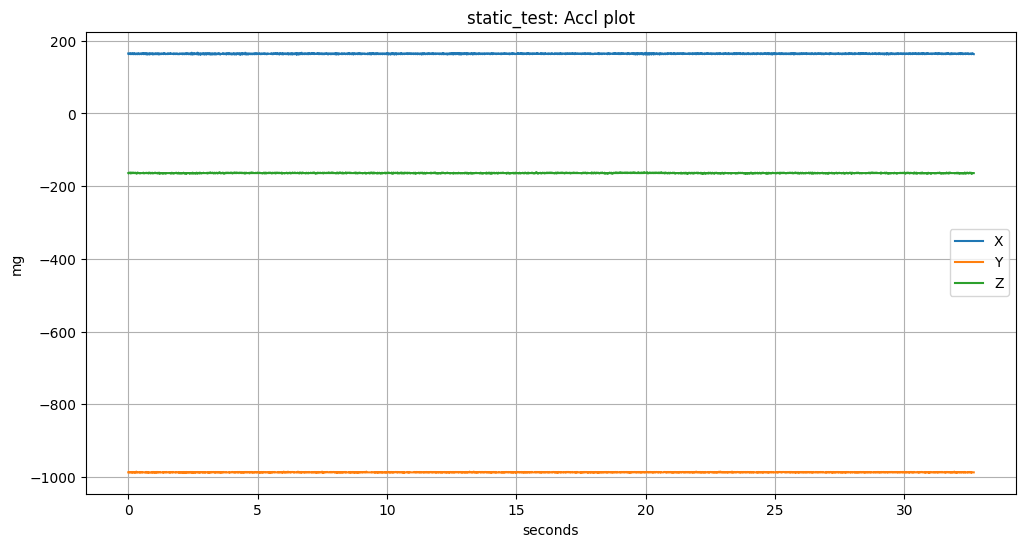

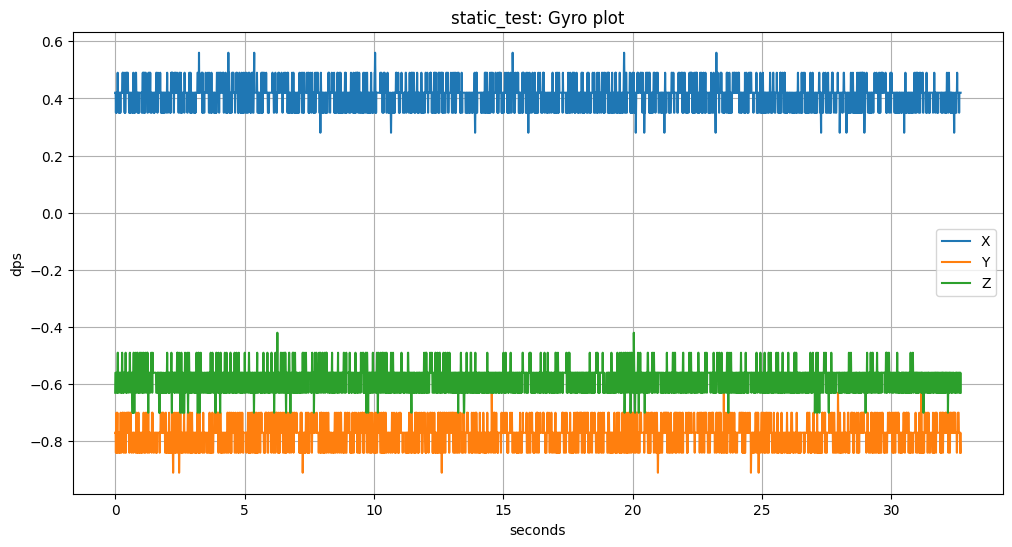

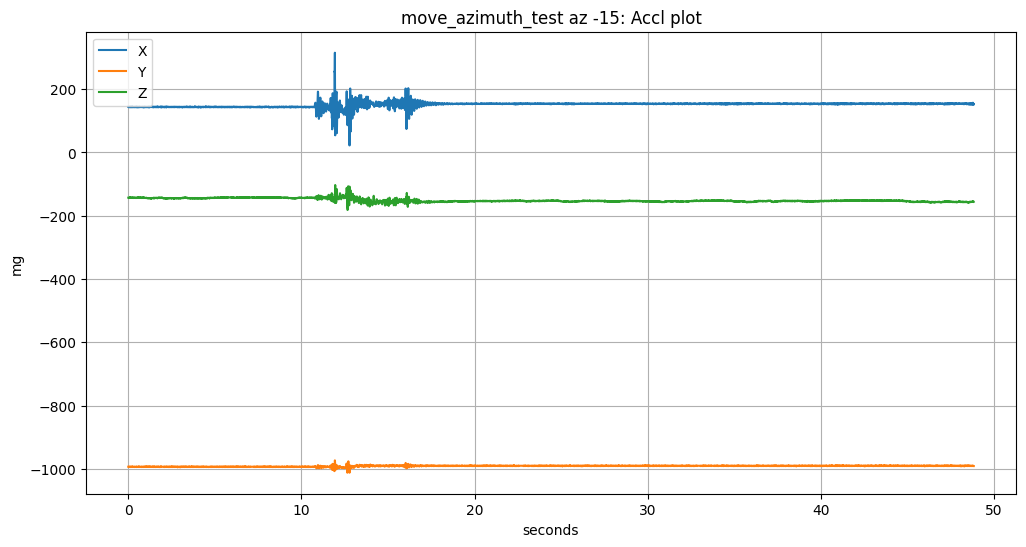

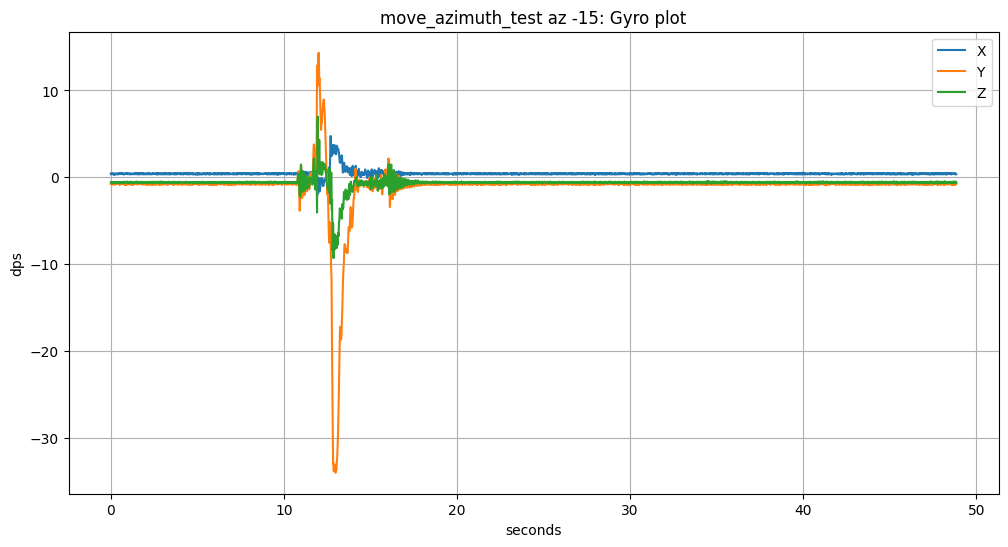

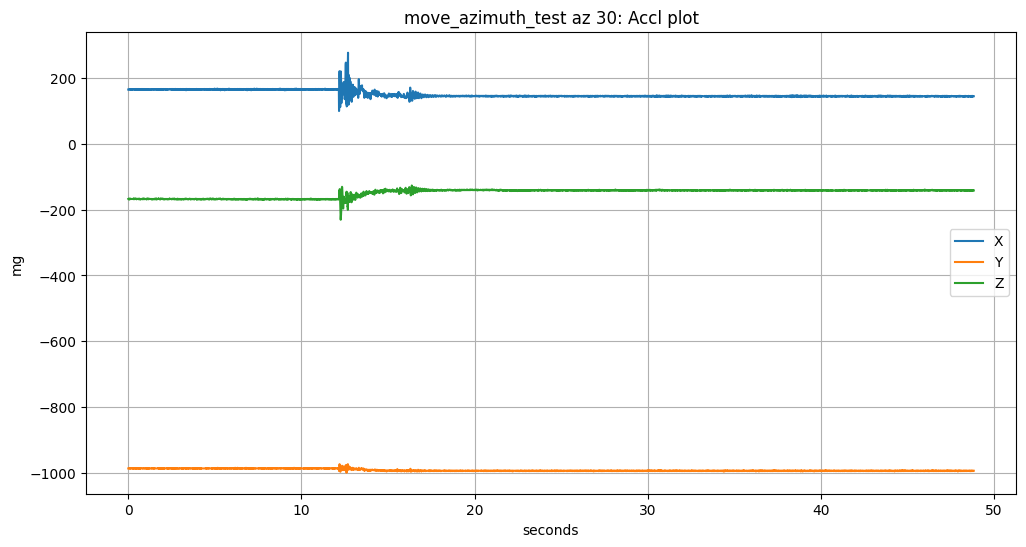

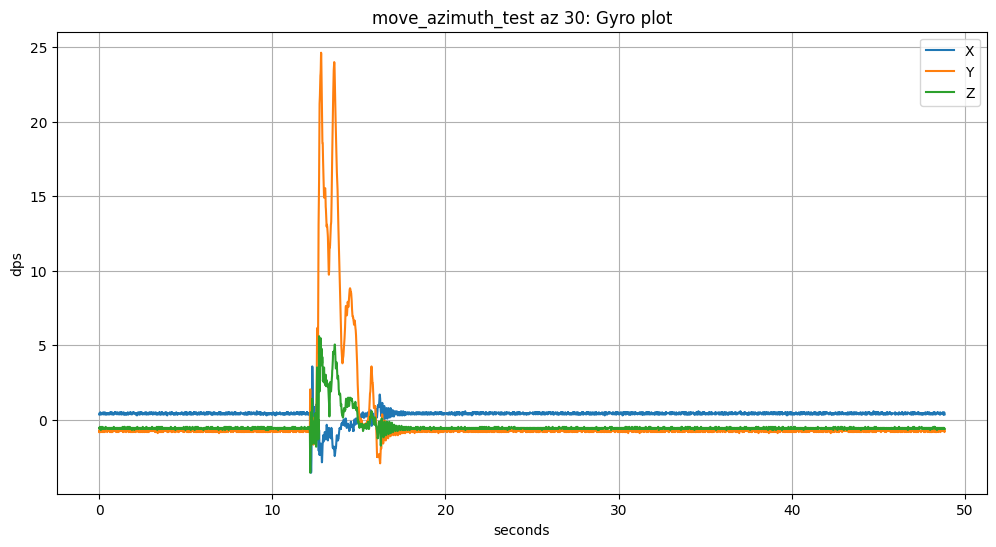

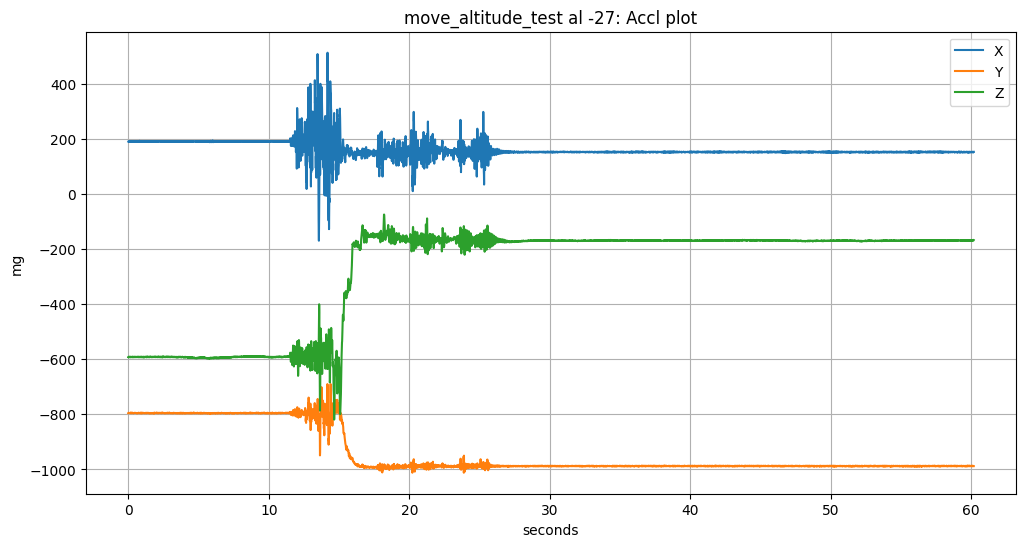

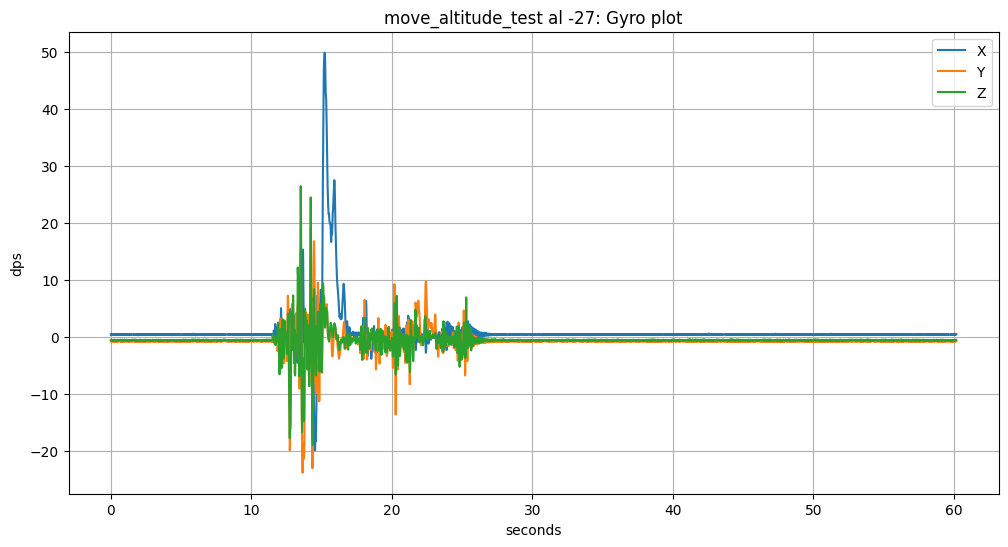

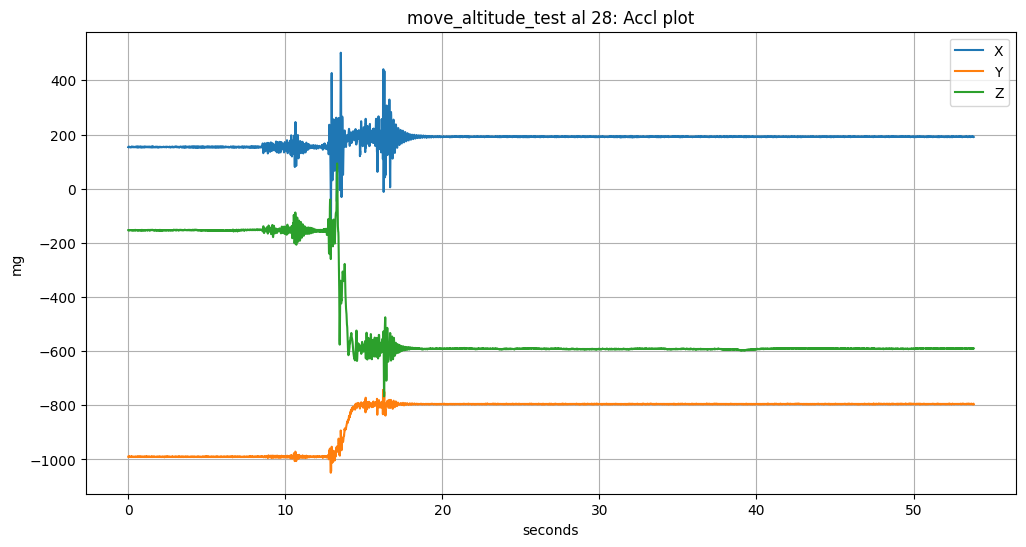

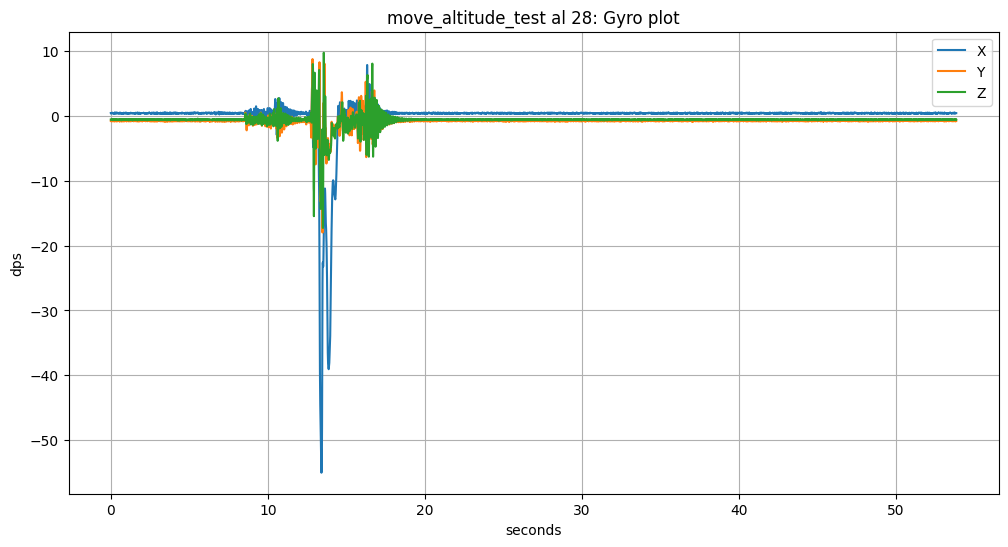

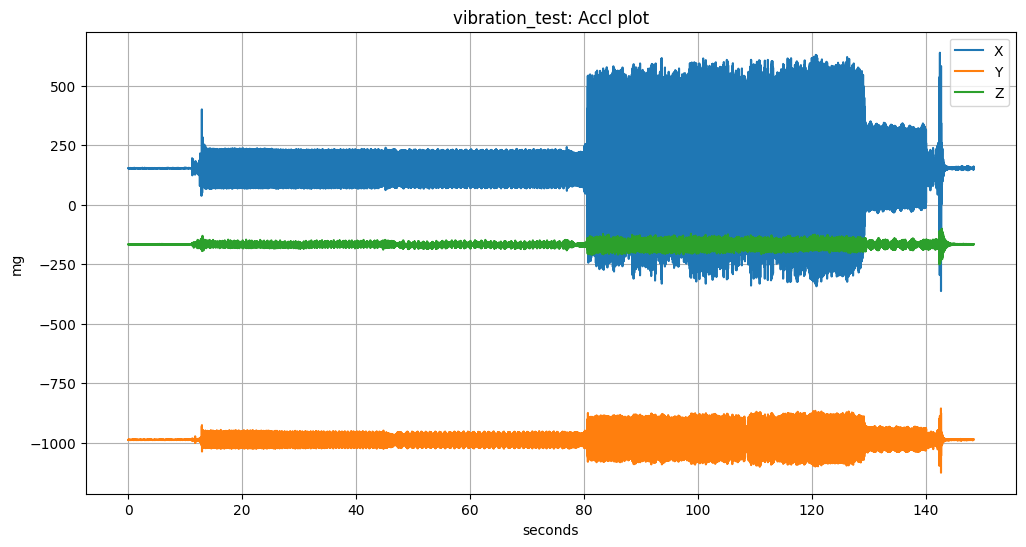

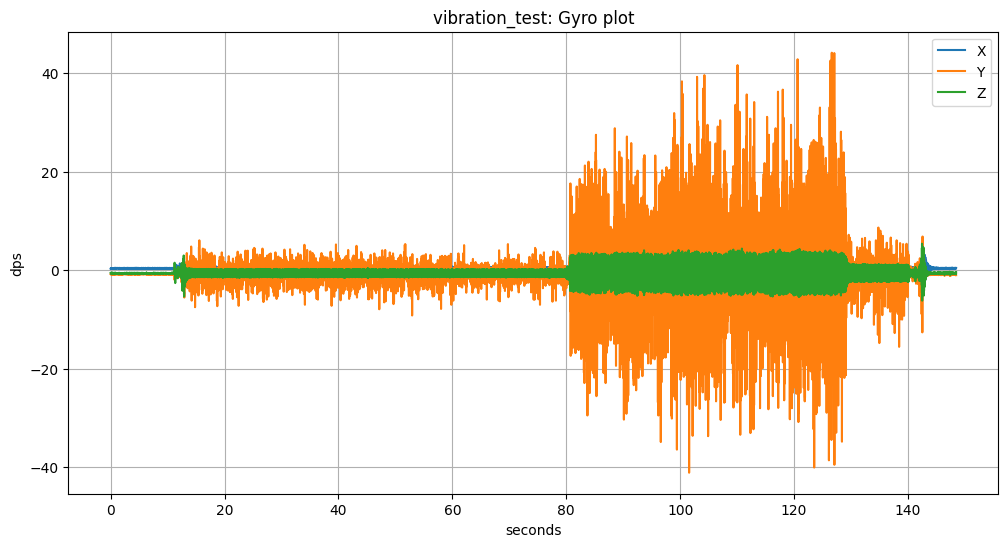

In [32]:
def plot_accel(acc_data, unit="mg", title="", timestamps=None):
    plt.figure(figsize=(12, 6))
    if timestamps is None:
        plt.plot(acc_data)
        plt.xlabel("samples")
    else:
        plt.plot(timestamps, acc_data)
        plt.xlabel("seconds")
    plt.title(title)
    plt.ylabel(unit)
    plt.legend(['X', 'Y', 'Z'])
    plt.grid(True)
    plt.show()


def plot_gyro(gyr_data, unit="dps", title="", timestamps=None):
    plt.figure(figsize=(12, 6))
    if timestamps is None:
        plt.plot(gyr_data)
        plt.xlabel("samples")
    else:
        plt.plot(timestamps, gyr_data)
        plt.xlabel("seconds")
    plt.title(title)
    plt.ylabel(unit)
    plt.legend(['X', 'Y', 'Z'])
    plt.grid(True)
    plt.show()


def plot_angles(roll, pitch, yaw=None, title="", unit="deg", timestamps=None):
    plt.figure(figsize=(12, 6))
    if timestamps is None:
        plt.plot(roll, label="Roll")
        plt.plot(pitch, label="Pitch")
        if yaw is not None:
            plt.plot(yaw, label="Yaw")
        plt.xlabel("samples")
    else:
        plt.plot(timestamps, roll, label="Roll")
        plt.plot(timestamps, pitch, label="Pitch")
        if yaw is not None:
            plt.plot(timestamps, yaw, label="Yaw")
        plt.xlabel("seconds")
    plt.ylabel(unit)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

for k,i in datasets.items():
    acc_data_mg = i[0][['accel_x_mg', 'accel_y_mg', 'accel_z_mg']].values
    gyro_data_mdps = i[0][['gyro_x_mdps', 'gyro_y_mdps', 'gyro_z_mdps']].values
    gyro_data_dps = i[0][['gyro_x_dps', 'gyro_y_dps', 'gyro_z_dps']].values
    plot_accel(acc_data_mg, timestamps=i[1], title=f"{k}: Accl plot")
    plot_gyro(gyro_data_dps,timestamps=i[1], title=f"{k}: Gyro plot")

In [48]:
def calculate_accel_angles_wds(df):
    ax = df["accel_x_mg"].values / 1000.0
    ay = df["accel_y_mg"].values / 1000.0
    az = df["accel_z_mg"].values / 1000.0

    magnitude = np.sqrt(ax ** 2 + ay ** 2 + az ** 2)
    low_acc_mask = magnitude < 0.5
    high_acc_mask = magnitude > 1.5

    roll = np.arctan2(ax, az) * RAD_TO_DEG
    pitch = np.arctan2(ay, az) * RAD_TO_DEG
    yaw = np.zeros_like(roll)

    reliable_mask = ~(low_acc_mask | high_acc_mask)
    return roll, pitch, yaw, reliable_mask

In [42]:
def remove_gyro_bias(df, static_seconds=5.0):
    window_size = int(static_seconds * FS)
    bias_x = df['gyro_x_dps'].rolling(window=window_size, center=True).mean()
    bias_y = df['gyro_y_dps'].rolling(window=window_size, center=True).mean()
    bias_z = df['gyro_z_dps'].rolling(window=window_size, center=True).mean()

    bias_x = bias_x.bfill().ffill()
    bias_y = bias_y.bfill().ffill()
    bias_z = bias_z.bfill().ffill()

    gyro_x_clean = df['gyro_x_dps'] - bias_x
    gyro_y_clean = df['gyro_y_dps'] - bias_y
    gyro_z_clean = df['gyro_z_dps'] - bias_z

    print(f"Moving window bias removal (window: {static_seconds}s)")
    return gyro_x_clean, gyro_y_clean, gyro_z_clean

def integrate_gyro_to_angles(df, sample_rate_hz=FS, static_seconds=5.0):
    gyro_x_clean, gyro_y_clean, gyro_z_clean = remove_gyro_bias(df, static_seconds)
    
    dt = 1.0 / sample_rate_hz
    
    # Cumulative integration (will show drift)
    gyro_roll_integrated = np.cumsum(gyro_x_clean) * dt
    gyro_pitch_integrated = np.cumsum(gyro_y_clean) * dt  
    gyro_yaw_integrated = np.cumsum(gyro_z_clean) * dt
    
    return gyro_roll_integrated, gyro_pitch_integrated, gyro_yaw_integrated

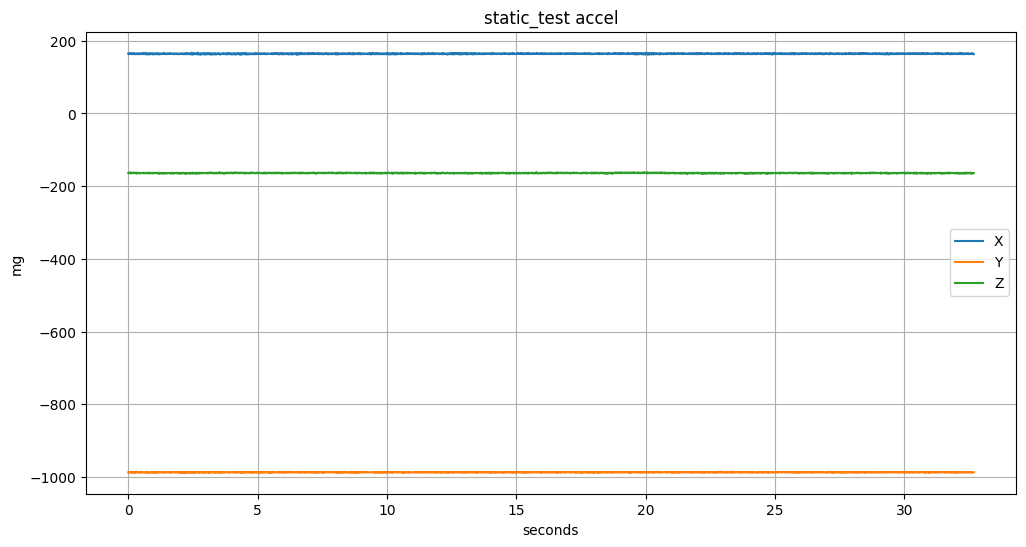

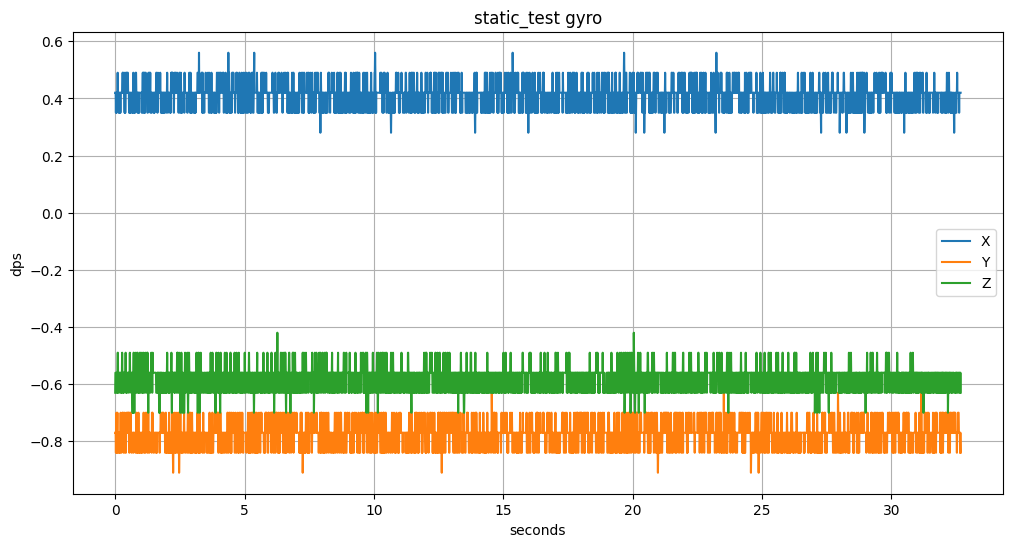

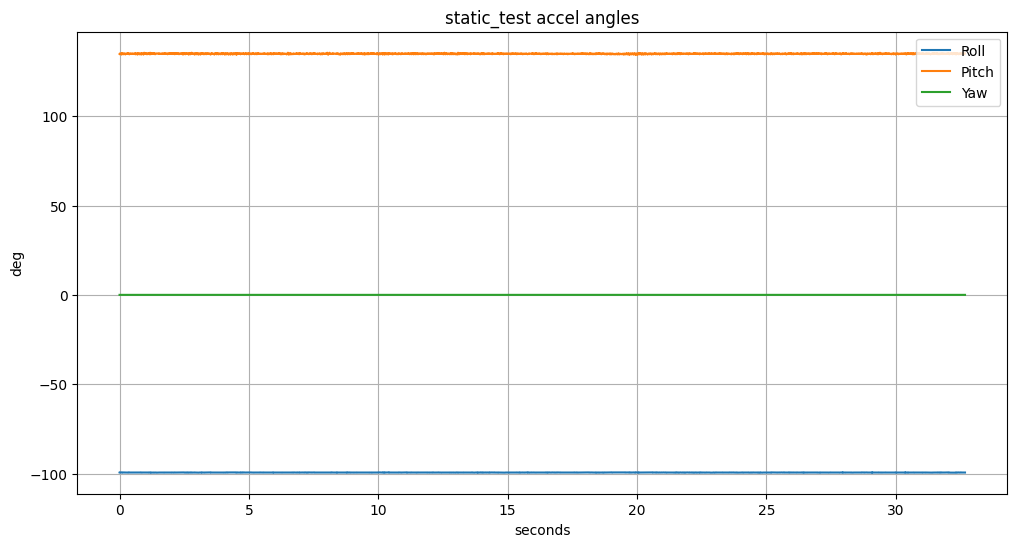

Moving window bias removal (window: 5.0s)


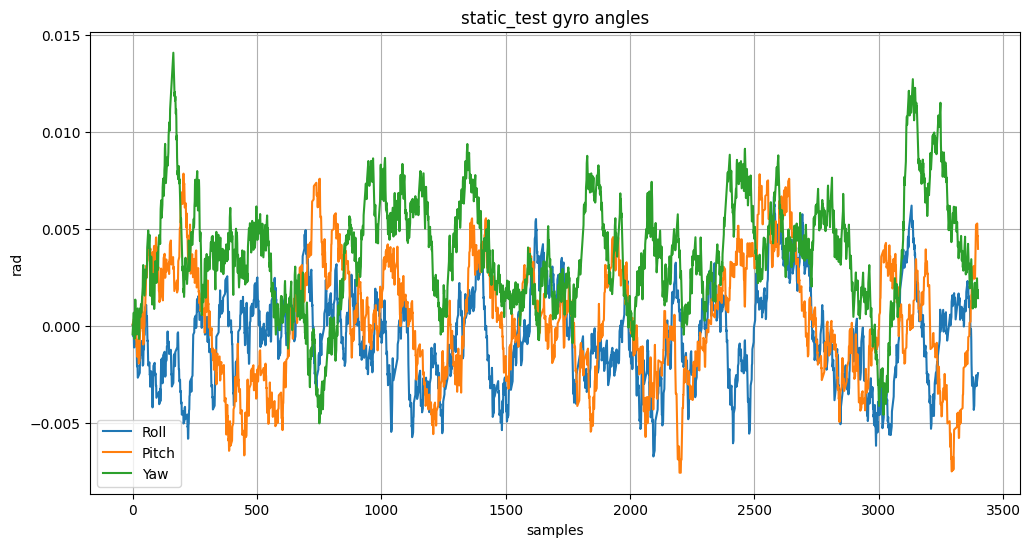

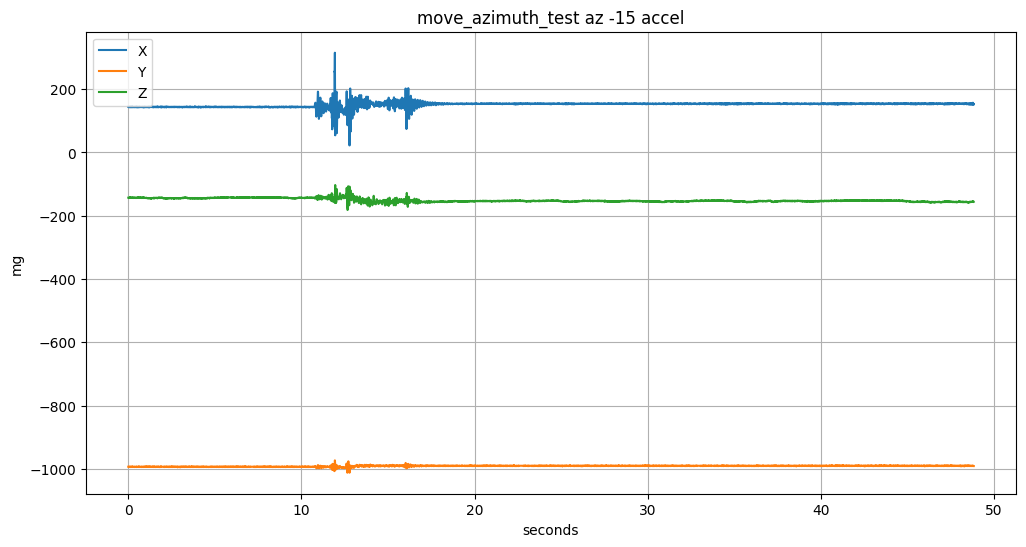

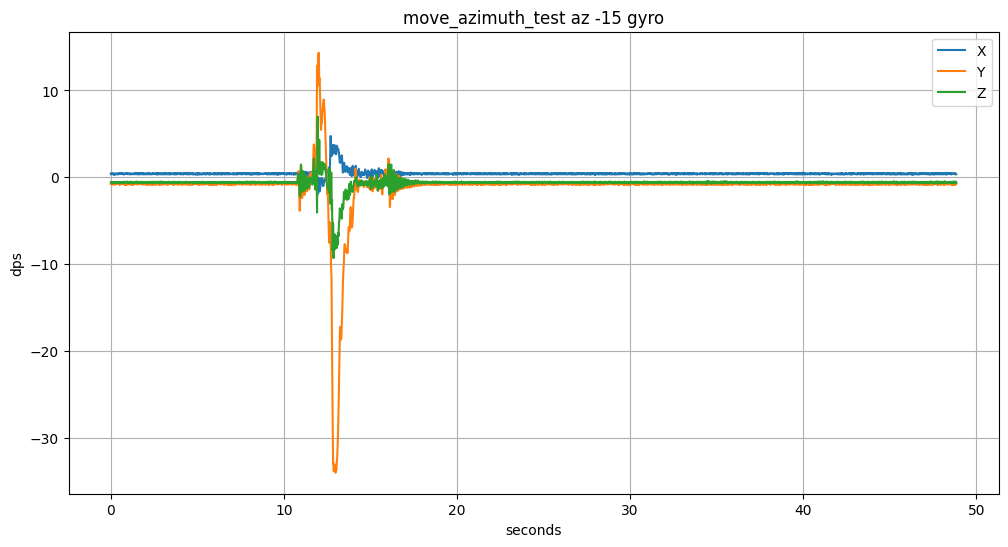

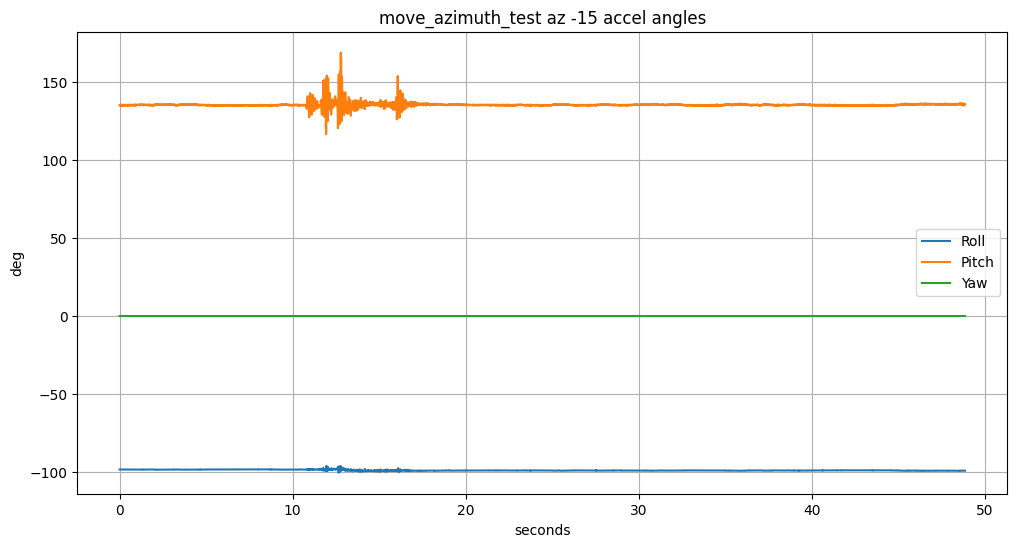

Moving window bias removal (window: 5.0s)


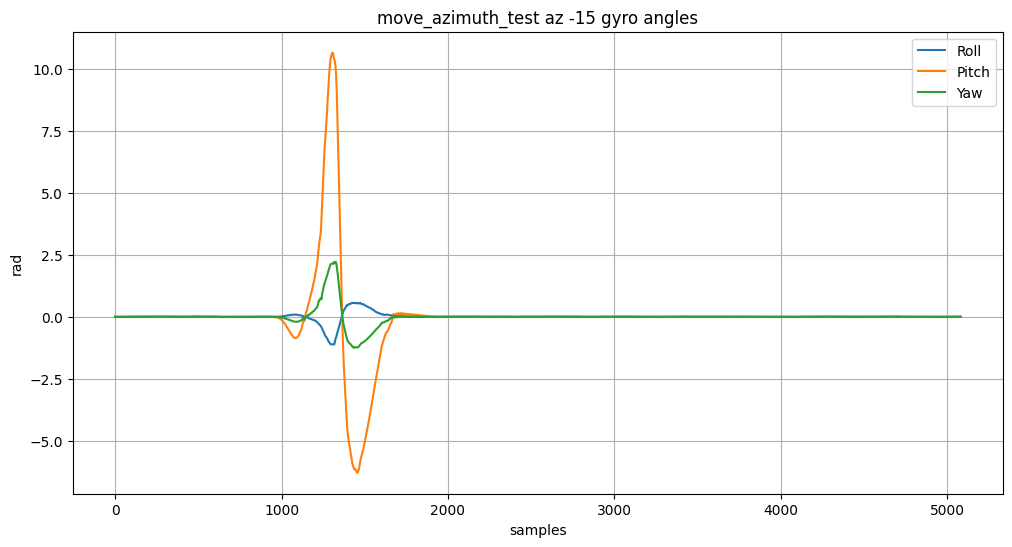

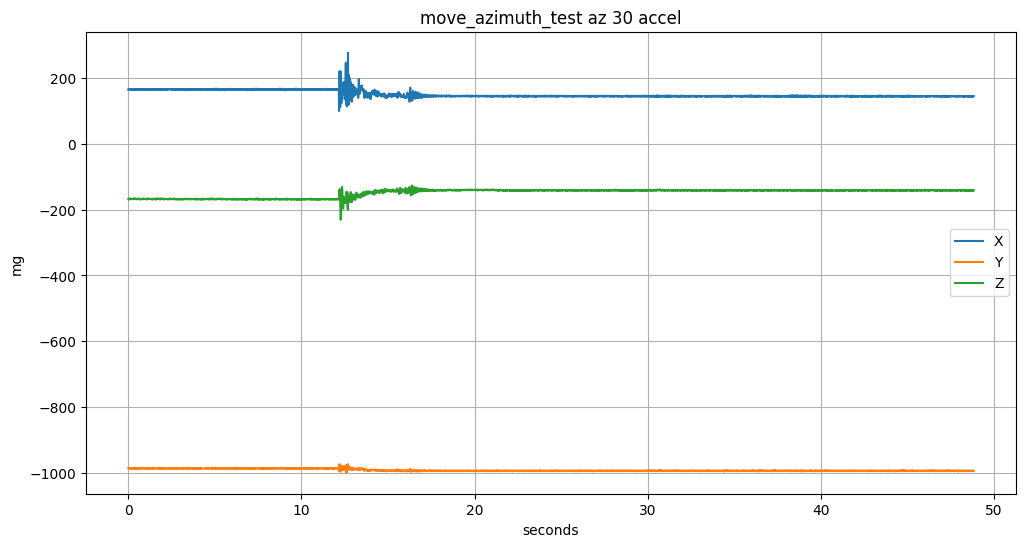

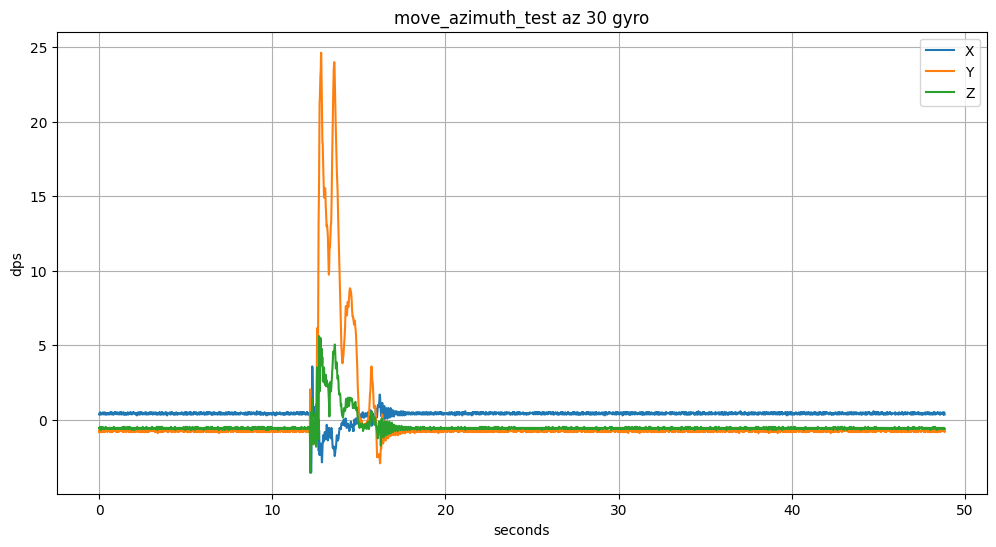

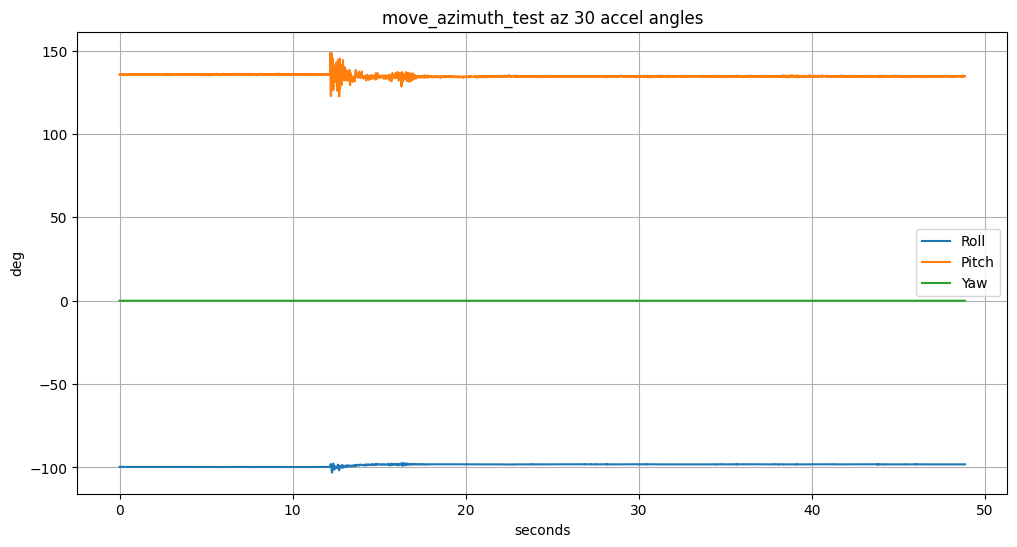

Moving window bias removal (window: 5.0s)


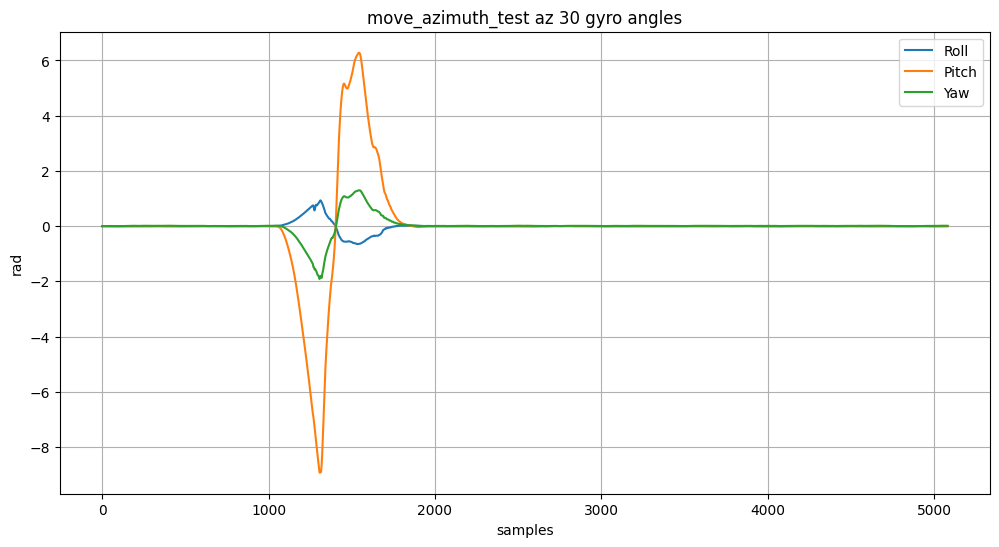

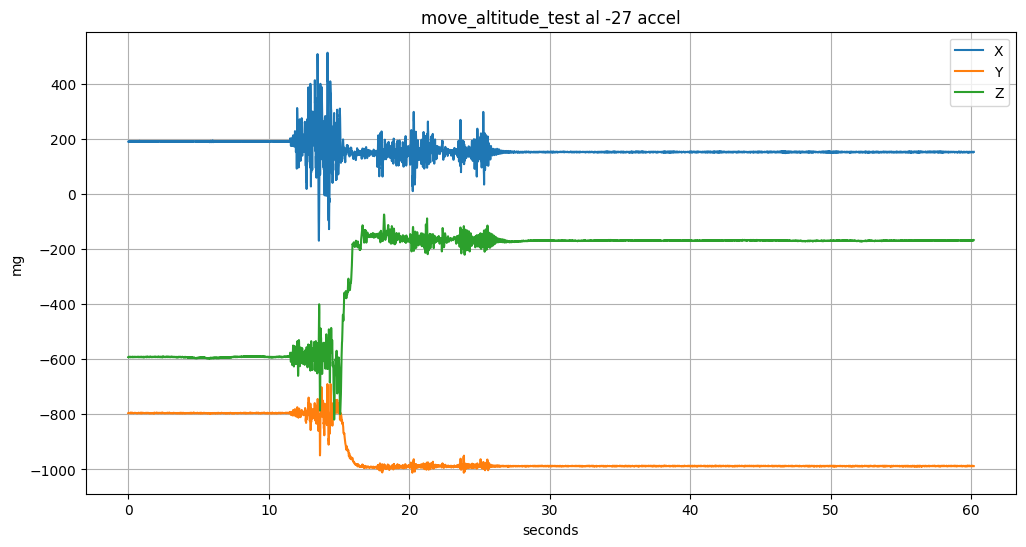

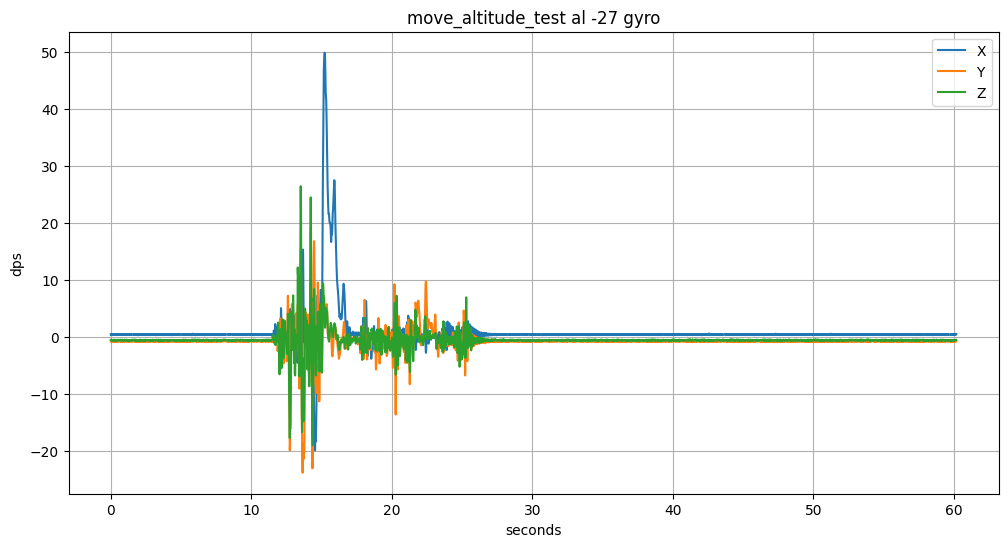

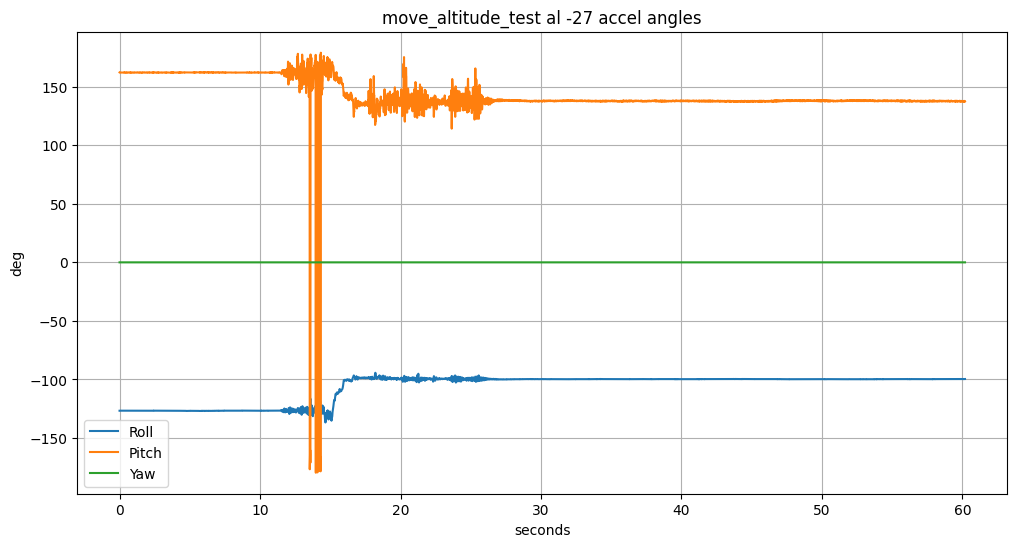

Moving window bias removal (window: 5.0s)


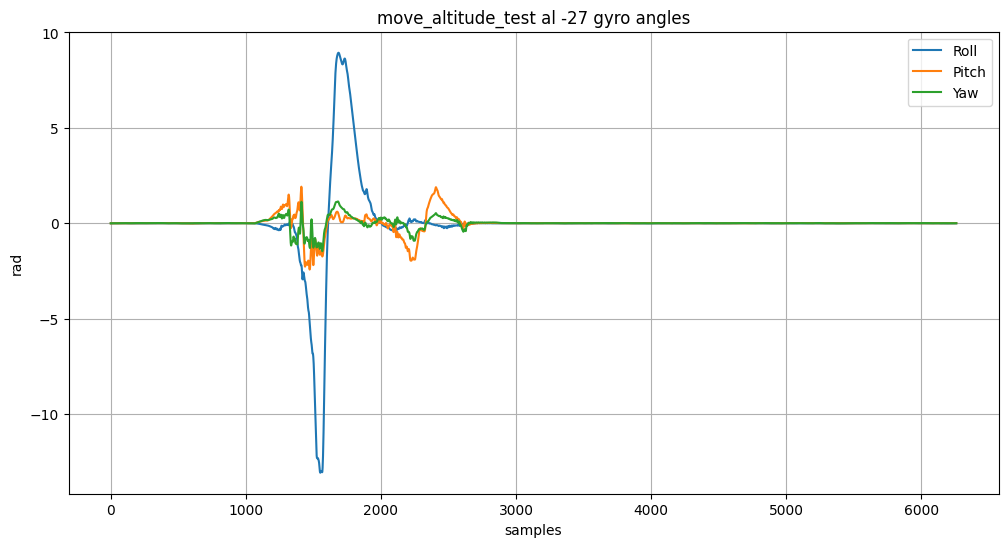

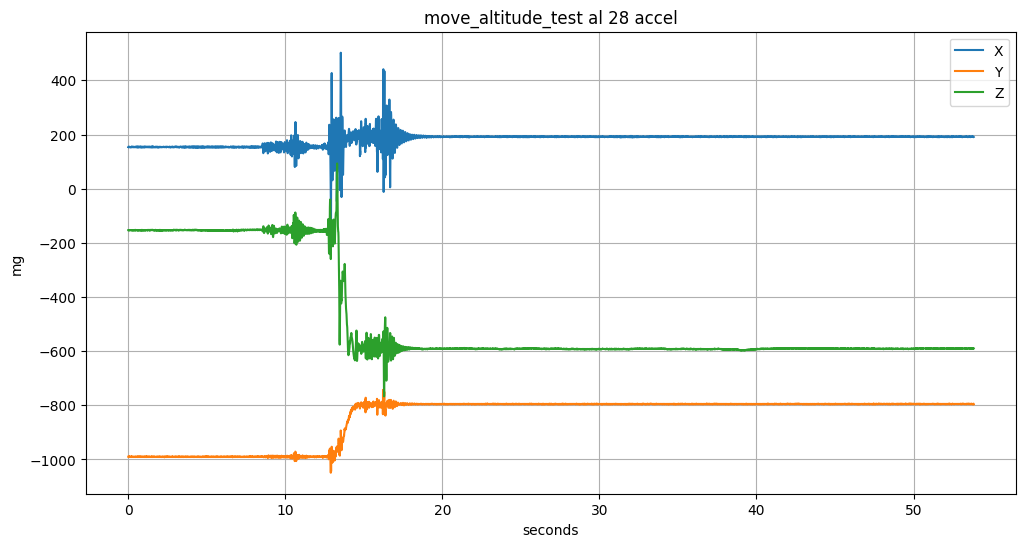

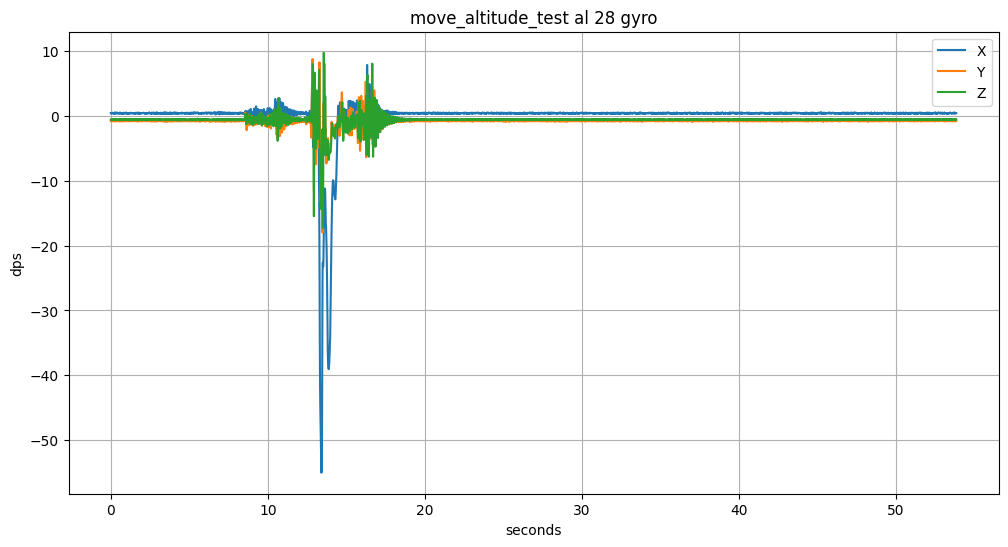

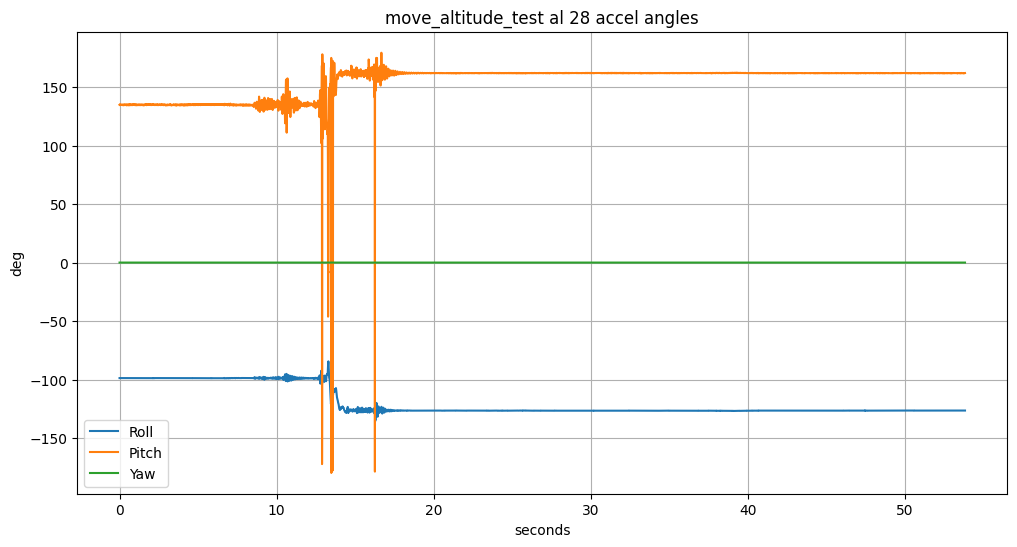

Moving window bias removal (window: 5.0s)


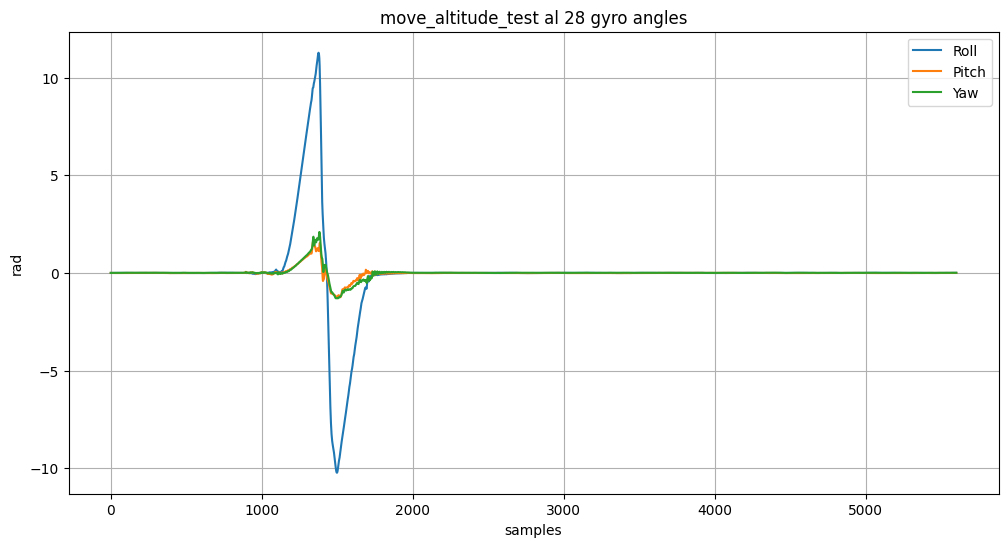

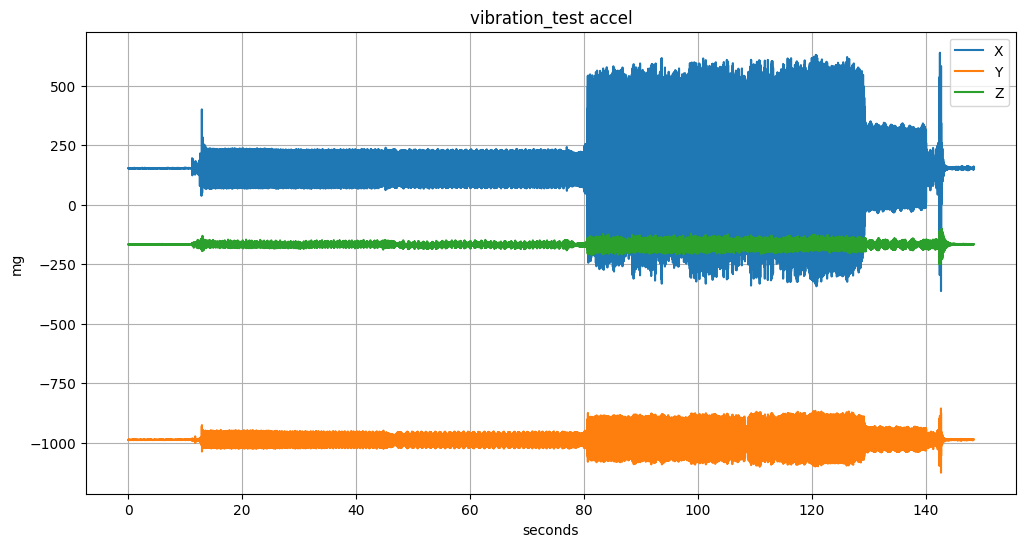

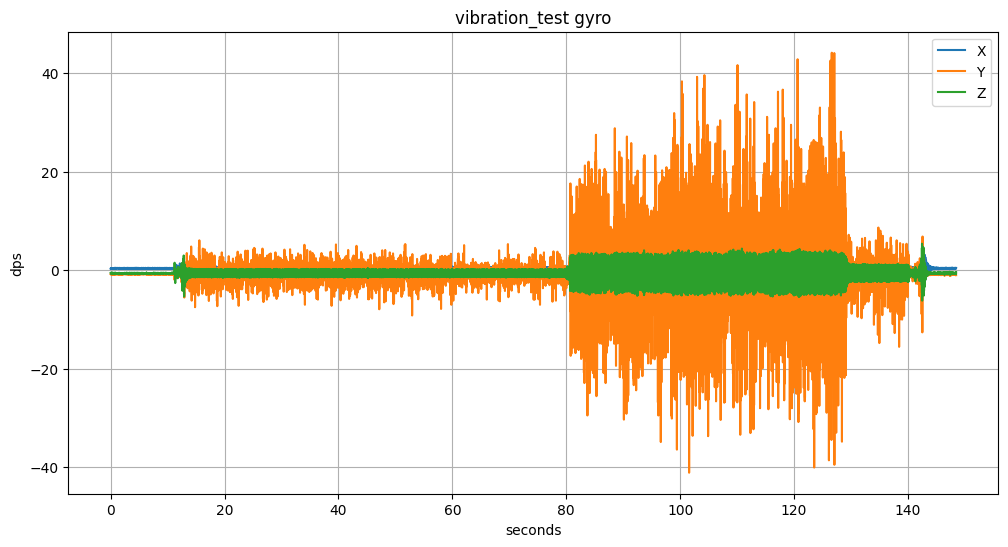

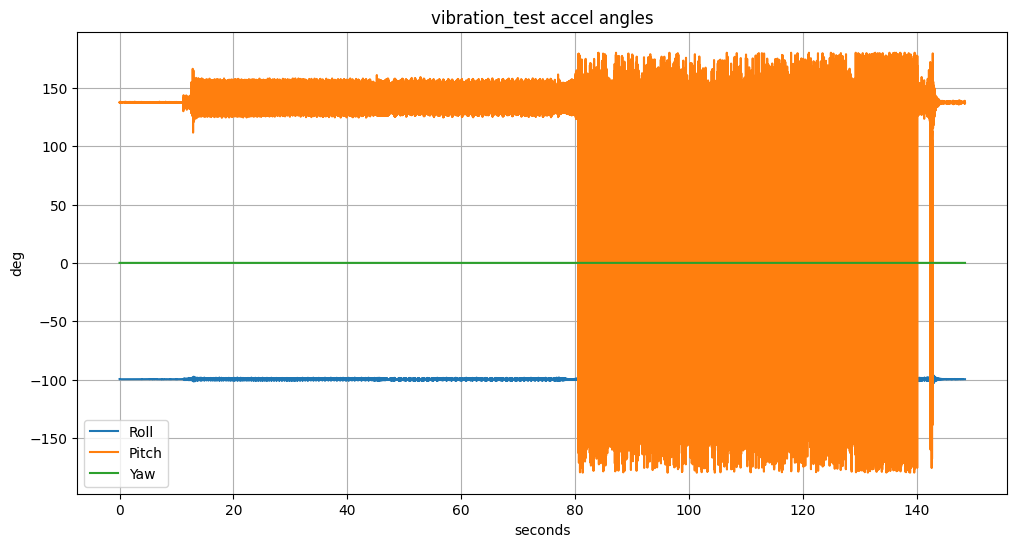

Moving window bias removal (window: 5.0s)


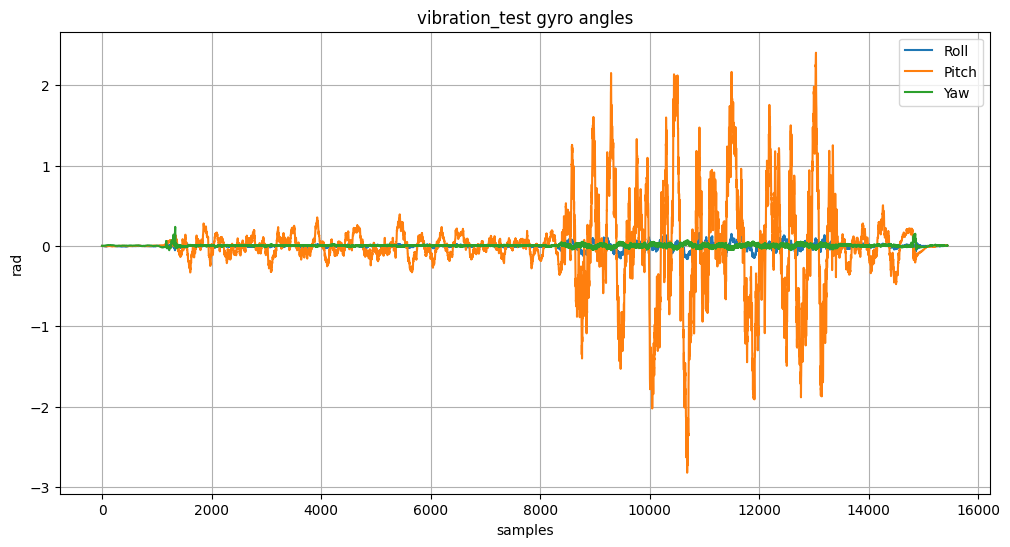

In [43]:
for name, (df, ts, _) in datasets.items():
    acc = df[["accel_x_mg", "accel_y_mg", "accel_z_mg"]].values
    gyr = df[["gyro_x_dps", "gyro_y_dps", "gyro_z_dps"]].values
    plot_accel(acc, timestamps=ts, title=f"{name} accel")
    plot_gyro(gyr, timestamps=ts, title=f"{name} gyro")

    roll_a, pitch_a, yaw_a, _ = calculate_accel_angles_wds(df)
    plot_angles(roll_a, pitch_a, yaw_a, timestamps=ts, title=f"{name} accel angles")

    roll_g, pitch_g, yaw_g = integrate_gyro_to_angles(df)
    plot_angles(roll_g, pitch_g, yaw_g, unit="rad", title=f"{name} gyro angles")


# Add Simple Sliding Window Filter to remove noise in Acc and Gyro

In [44]:
def sliding_window_filter(data, window_size=5):
    """Simple moving average filter"""
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')
def filter_imu_data(acc_data, gyro_data, window_size=5):
    """Apply sliding window filter to both acc and gyro data"""
    acc_filtered = np.zeros_like(acc_data)
    gyro_filtered = np.zeros_like(gyro_data)
    
    for i in range(3):
        acc_filtered[:, i] = sliding_window_filter(acc_data[:, i], window_size)
        gyro_filtered[:, i] = sliding_window_filter(gyro_data[:, i], window_size)
    
    return acc_filtered, gyro_filtered

# ADD Simple Complementery filter to combine acc with gyro

In [45]:
def complementary_filter(acc_angles, gyro_angles, alpha=0.98, dt=DT):
    """Simple complementary filter combining acc and gyro angles"""
    n_samples = len(acc_angles)
    filtered_angles = np.zeros((n_samples, 3))
    
    filtered_angles[0] = acc_angles[0]
    
    for i in range(1, n_samples):
        gyro_delta = gyro_angles[i] - gyro_angles[i-1]
        
        # Complementary filter
        filtered_angles[i, 0] = alpha * (filtered_angles[i-1, 0] + gyro_delta[0]) + (1-alpha) * acc_angles[i, 0]  # Roll
        filtered_angles[i, 1] = alpha * (filtered_angles[i-1, 1] + gyro_delta[1]) + (1-alpha) * acc_angles[i, 1]  # Pitch
        filtered_angles[i, 2] = filtered_angles[i-1, 2] + gyro_delta[2]  # Yaw (only gyro)
    
    return filtered_angles

# Add Logic to detect sudden angle changes in altitude and azimuth on Complementery filter output (angle change larger than 5 - 10 degrees within a second or two and it then stays at that angle)

In [49]:
def detect_sudden_changes(angles, timestamps, altitude_threshold=1.0, azimuth_threshold=5.0, time_window=2.0):
    """
    Detect sudden angle changes in altitude and azimuth
    For WDS orientation: Roll=altitude, Yaw=azimuth (adjust based on your setup)
    """
    detections = []
    fs = len(timestamps) / (timestamps[-1] - timestamps[0])
    window_samples = int(time_window * fs)
    
    for i in range(window_samples, len(angles) - window_samples):
        # Look at change over time window
        start_idx = i - window_samples
        end_idx = i + window_samples
        
        # Check all axes for changes
        roll_change = abs(angles[end_idx, 0] - angles[start_idx, 0])   # Roll (X-axis)
        pitch_change = abs(angles[end_idx, 1] - angles[start_idx, 1])  # Pitch (Y-axis)
        yaw_change = abs(angles[end_idx, 2] - angles[start_idx, 2])    # Yaw (Z-axis)
        
        # For WDS orientation, determine which axis represents altitude/azimuth
        # Based on your plot, Roll seems to be the altitude change
        if roll_change > altitude_threshold:
            detections.append({
                'time': timestamps[i],
                'type': 'altitude',
                'change': roll_change,
                'angle': 'roll'
            })
        
        if pitch_change > altitude_threshold:
            detections.append({
                'time': timestamps[i],
                'type': 'altitude_pitch',
                'change': pitch_change,
                'angle': 'pitch'
            })
            
        if yaw_change > azimuth_threshold:
            detections.append({
                'time': timestamps[i], 
                'type': 'azimuth',
                'change': yaw_change,
                'angle': 'yaw'
            })
    
    return detections


=== static_test ===
Moving window bias removal (window: 5.0s)


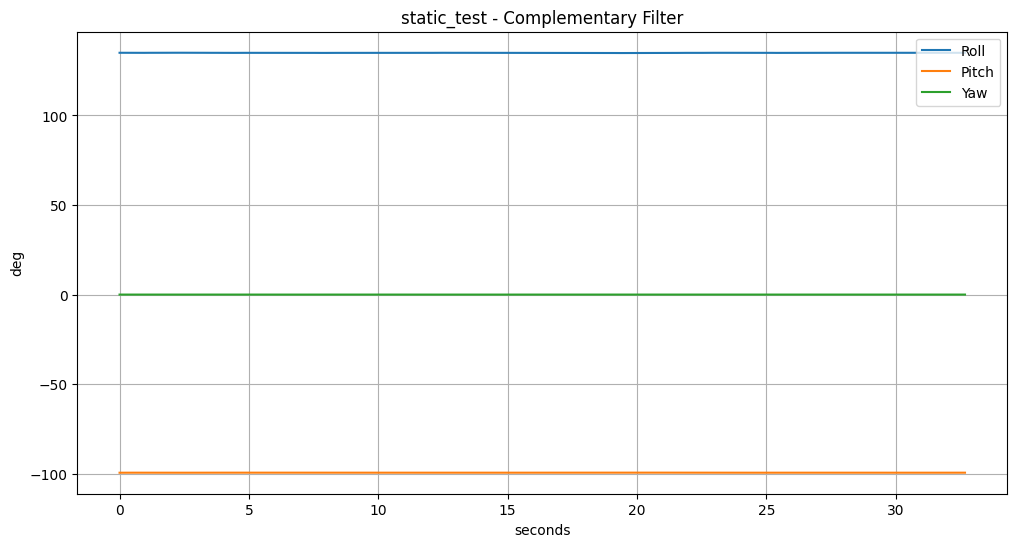

No sudden changes detected

=== move_azimuth_test az -15 ===
Moving window bias removal (window: 5.0s)


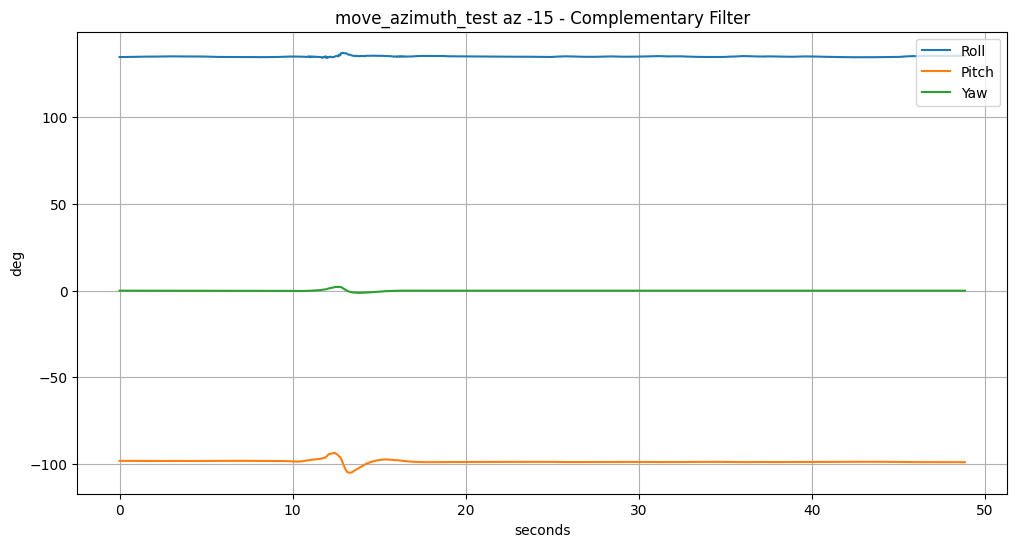

Detections: 786
  9.48s: altitude_pitch change of 1.00°
  9.49s: altitude_pitch change of 1.00°
  9.50s: altitude_pitch change of 1.01°
  9.51s: altitude_pitch change of 1.02°
  9.52s: altitude_pitch change of 1.03°

=== move_azimuth_test az 30 ===
Moving window bias removal (window: 5.0s)


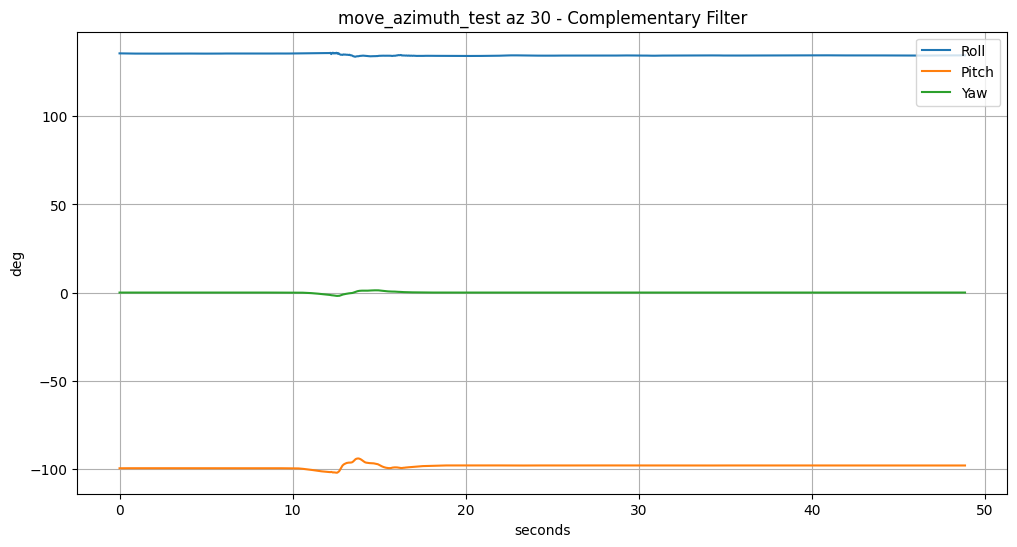

Detections: 1266
  9.14s: altitude_pitch change of 1.01°
  9.15s: altitude_pitch change of 1.02°
  9.16s: altitude_pitch change of 1.04°
  9.17s: altitude_pitch change of 1.05°
  9.18s: altitude_pitch change of 1.07°

=== move_altitude_test al -27 ===
Moving window bias removal (window: 5.0s)


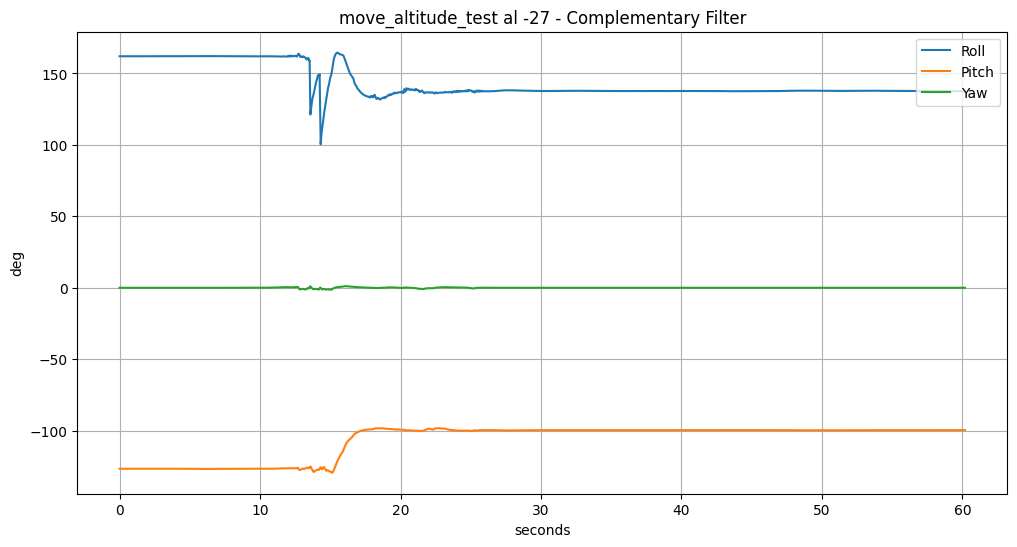

Detections: 2045
  10.69s: altitude change of 1.17°
  10.70s: altitude change of 1.37°
  10.71s: altitude change of 1.56°
  10.72s: altitude change of 1.67°
  10.73s: altitude change of 1.72°

=== move_altitude_test al 28 ===
Moving window bias removal (window: 5.0s)


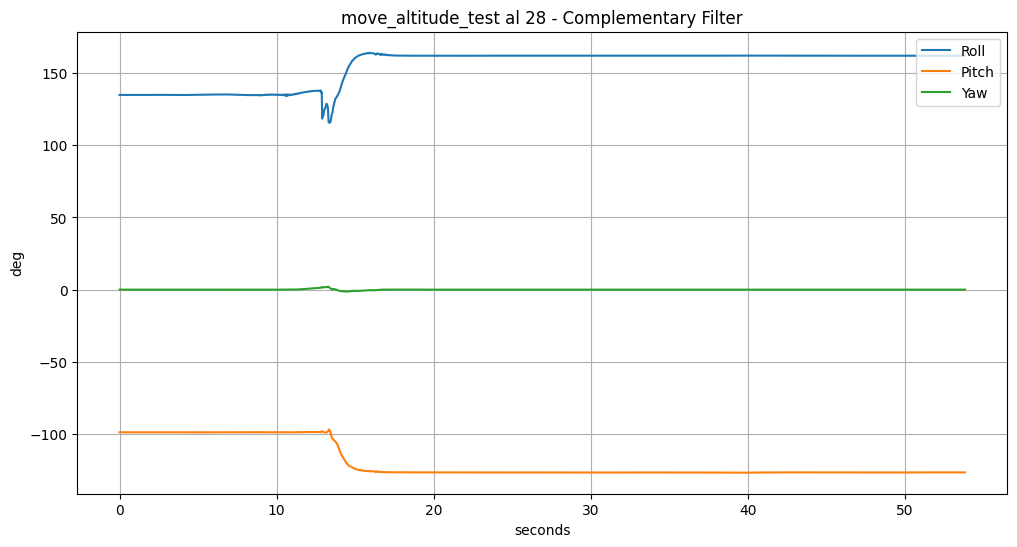

Detections: 1568
  9.41s: altitude change of 1.02°
  9.42s: altitude change of 1.08°
  9.43s: altitude change of 1.12°
  9.44s: altitude change of 1.13°
  9.45s: altitude change of 1.12°

=== vibration_test ===
Moving window bias removal (window: 5.0s)


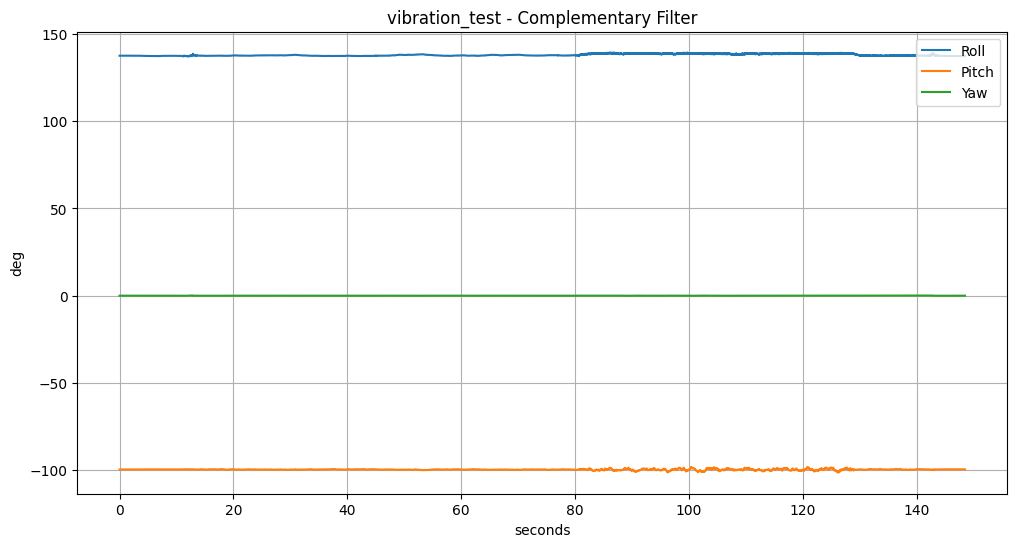

Detections: 1535
  10.87s: altitude change of 1.07°
  10.87s: altitude change of 1.12°
  10.88s: altitude change of 1.20°
  10.89s: altitude change of 1.05°
  14.87s: altitude change of 1.03°


In [53]:
for name, (df, ts, mdps) in datasets.items():
    print(f"\n=== {name} ===")
    
    # Get raw data
    acc_raw = df[["accel_x_mg", "accel_y_mg", "accel_z_mg"]].values
    gyro_raw = df[["gyro_x_dps", "gyro_y_dps", "gyro_z_dps"]].values
    
    # Apply sliding window filter
    acc_filtered, gyro_filtered = filter_imu_data(acc_raw, gyro_raw, window_size=5)
    
    # Calculate angles from filtered accelerometer
    df_filtered = df.copy()
    df_filtered["accel_x_mg"] = acc_filtered[:, 0]
    df_filtered["accel_y_mg"] = acc_filtered[:, 1] 
    df_filtered["accel_z_mg"] = acc_filtered[:, 2]
    df_filtered["gyro_x_dps"] = gyro_filtered[:, 0]
    df_filtered["gyro_y_dps"] = gyro_filtered[:, 1]
    df_filtered["gyro_z_dps"] = gyro_filtered[:, 2]
    
    roll_a, pitch_a, yaw_a, _ = calculate_accel_angles_wds(df_filtered)
    roll_g, pitch_g, yaw_g = integrate_gyro_to_angles(df_filtered)
    
    # Apply complementary filter
    acc_angles = np.column_stack([roll_a, pitch_a, yaw_a])
    gyro_angles = np.column_stack([roll_g, pitch_g, yaw_g])
    comp_angles = complementary_filter(acc_angles, gyro_angles)
    
    # Detect sudden changes
    detections = detect_sudden_changes(comp_angles, ts)
    
    # Plot results
    plot_angles(comp_angles[:, 0], comp_angles[:, 1], comp_angles[:, 2], 
               timestamps=ts, title=f"{name} - Complementary Filter")
    
    # Print detections
    if detections:
        print(f"Detections: {len(detections)}")
        for det in detections[:5]:  # Show first 5
            print(f"  {det['time']:.2f}s: {det['type']} change of {det['change']:.2f}°")
    else:
        print("No sudden changes detected")